In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

In [2]:
rho = 9.9035e3
mu = 4*np.pi*1e-7
Omega = 2*np.pi/86400
omega = -Omega

sigma_f = 5e5
#sigma_s = sigma_f

nu = 1e-6
rcmb = 3.48e6
Af = 9.0583e36 #MOI of the Core

ntheta = 1024
# Adjust ntheta to ensure (ntheta - 1) is not divisible by 3
if (ntheta - 1) % 3 == 0:
    ntheta += 1  # Increment ntheta to avoid pi/3

theta = np.linspace(0,np.pi,ntheta)

f = 2*Omega*np.cos(theta)

In [3]:
def get_diss(Br,sigma_s):

    eta_f = 1/(sigma_f*mu)
    eta_s = 1/(sigma_s*mu)

    lambda_s = -np.sqrt(1j * omega/eta_s)

    lambda1_pos = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(f + omega) - 
                                           np.sqrt(4*eta_f*nu*omega*(f + omega) + (Br**2/(mu*rho) + 1j*nu*omega
                                                                                   + 1j*eta_f*(f + omega))**2))/(eta_f*nu))
    
    lambda1_neg = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(omega - f) - 
                                           np.sqrt(4*eta_f*nu*omega*(omega - f) + (Br**2/(mu*rho) + 1j*nu*omega
                                                                                   + 1j*eta_f*(omega - f))**2))/(eta_f*nu))
    
    lambda2_pos = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(f + omega) +
                                           np.sqrt(4*eta_f*nu*omega*(f + omega) + (Br**2/(mu*rho) + 1j*nu*omega
                                                                                   + 1j*eta_f*(f + omega))**2))/(eta_f*nu))
    
    lambda2_neg = 1./np.sqrt(2) * np.sqrt((Br**2/(mu*rho) + 1j*nu*omega + 1j*eta_f*(omega - f) +
                                           np.sqrt(4*eta_f*nu*omega*(omega - f) + (Br**2/(mu*rho) + 1j*nu*omega
                                                                                   + 1j*eta_f*(omega - f))**2))/(eta_f*nu))
    
    F_pos = ( (eta_f * lambda1_pos - eta_s*lambda_s) * ( 1j*omega/lambda2_pos - eta_f*lambda2_pos )  -  (eta_f * lambda2_pos - eta_s * lambda_s) * ( 1j*omega/lambda1_pos - eta_f*lambda1_pos ) )
             
    F_neg = ( (eta_f * lambda1_neg - eta_s*lambda_s) * ( 1j*omega/lambda2_neg - eta_f*lambda2_neg )  -  (eta_f * lambda2_neg - eta_s * lambda_s) * ( 1j*omega/lambda1_neg - eta_f*lambda1_neg ) )
    
    F1_pos = -(eta_f * lambda2_pos - eta_s * lambda_s)/F_pos
    F1_neg = -(eta_f * lambda2_neg - eta_s * lambda_s)/F_neg
    F2_pos = (eta_f * lambda1_pos - eta_s * lambda_s)/F_pos
    F2_neg = (eta_f * lambda1_neg - eta_s * lambda_s)/F_neg
    
    Iem = Br**2 * ( (1 + np.cos(theta))**2 * (F1_pos + F2_pos) + 
                   (1 - np.cos(theta))**2 * (F1_neg + F2_neg) )

    Ivisc = ( (1 + np.cos(theta))**2 * (1j * omega * (F1_pos + F2_pos) - eta_f * (F1_pos * lambda1_pos**2 + F2_pos * lambda2_pos**2))
             + (1 - np.cos(theta))**2 * (1j * omega * (F1_neg + F2_neg) - eta_f * (F1_neg * lambda1_neg**2 + F2_neg * lambda2_neg**2))
            )

    IemInt = (np.pi*rcmb**4)/(2*1j*Omega*Af) * 1/mu * simpson(Iem * np.sin(theta),x=theta)
    IviscInt = (np.pi*rcmb**4)/(2*1j*Omega*Af) * rho * nu * simpson(Ivisc * np.sin(theta),x=theta)
    
    return Iem, IemInt, Ivisc, IviscInt

In [4]:
Br_rms = 2.613779e-4
Br_dip = np.sqrt(3) * Br_rms * np.cos(theta)
Br_uni = np.linspace(0,1,100)*1e-3

log_sigma_array = np.array([0, -1, -2])
sigma_array = 10.**log_sigma_array * sigma_f
sigma_legend = [rf'$\sigma_{{\mathrm{{m}}}} = \sigma_{{\mathrm{{f}}}}$',rf'$\sigma_{{\mathrm{{m}}}} = 10^{{-1}} \times \sigma_{{\mathrm{{f}}}}$',rf'$\sigma_{{\mathrm{{m}}}} = 10^{{-2}} \times \sigma_{{\mathrm{{f}}}}$']

Kcmb_real = np.zeros((len(sigma_array), len(Br_uni)))
Kcmb_imag = np.zeros((len(sigma_array), len(Br_uni)))

for i, sigma in enumerate (sigma_array):
    Iem_dip, IemInt_dip, Ivisc_dip, IviscInt_dip = get_diss(Br_dip,sigma)

    for k, br in enumerate(Br_uni):
        Iem_uni, IemInt_uni, Ivisc_uni, IviscInt_uni = get_diss(br,sigma)
        total_diss = IemInt_uni + IviscInt_uni + IemInt_dip + IviscInt_dip
        Kcmb_real[i,k] = np.real(total_diss)
        Kcmb_imag[i,k] = np.imag(total_diss)

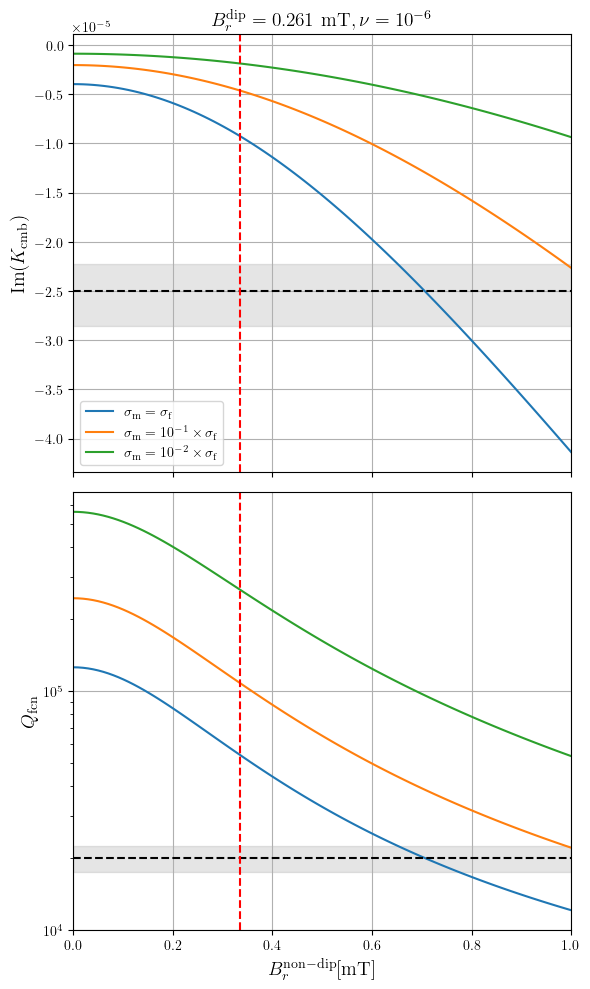

In [9]:
# Create a figure with two subplots (swapped order)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10), sharex=True)

# Set usetex for both subplots
plt.rc('text', usetex=True)

# First subplot: Kcmb (now on the left)
for i in range(Kcmb_imag.shape[0]):
    ax1.plot(Br_uni * 1e3, Kcmb_imag[i], label=sigma_legend[i])
ax1.set_xlim(min(Br_uni*1e3), max(Br_uni*1e3))
ax1.axhline(y=-1/(2*20000), color='k', linestyle='--')
ax1.fill_between(Br_uni*1e3, -1/(2*22500), -1/(2*17500), color='gray', alpha=0.2)
ax1.axvline(x=0.3344279, color='r', linestyle='--')
ax1.set_ylabel(r'$\mathrm{Im}(K_\mathrm{cmb})$', fontsize=14)
#ax1.set_xlabel(r'$B_r^\mathrm{non-dip} [\mathrm{mT}]$', fontsize=14)
ax1.set_title(r'$B_r^\mathrm{dip}=0.261~\mathrm{mT}, \nu=10^{-6}$', fontsize=14)
ax1.grid()
ax1.legend()

# Second subplot: Qcmb (now on the right)
for i in range(Kcmb_imag.shape[0]):
    ax2.semilogy(Br_uni * 1e3, -1/(2*Kcmb_imag[i]), label=sigma_legend[i])
ax2.set_xlim(min(Br_uni*1e3), max(Br_uni*1e3))
ax2.axhline(y=20000, color='k', linestyle='--')
ax2.fill_between(Br_uni*1e3, 17500, 22500, color='gray', alpha=0.2)
ax2.axvline(x=0.3344279, color='r', linestyle='--')
ax2.set_ylabel(r'$Q_\mathrm{fcn}$', fontsize=14)
ax2.set_xlabel(r'$B_r^\mathrm{non-dip} [\mathrm{mT}]$', fontsize=14)
#ax2.set_title(r'$B_r^\mathrm{dip}=0.261~\mathrm{mT}, \nu=10^{-6}$', fontsize=14)
ax2.grid()
#ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("KQcmb.pdf")

# Show the figure
plt.show()